In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import madrigalWeb.madrigalWeb
import os
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2024"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2019,5,10,0,0,0)
et=datetime.datetime(2019,5,11,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30002701
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30002701
url: http://data.amisr.com/madrigal/madtoc/experiments0/2019/pfa/10may19c
name: WorldDay35 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 5
startday: 10
starthour: 17
startmin: 0
startsec: 47
endyear: 2019
endmonth: 5
endday: 12
endhour: 22
endmin: 6
endsec: 5
isLocal: True
madrigalUrl: http://https://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1720831154
access: 0
Madrigal version: 3.4



In [5]:
# Get all the files associated with the experiment:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print(os.path.basename(file.name),'\tkindat:',file.kindat,'desc:',file.kindatdesc)

pfa20190510.003_ac_nenotr_01min.002.h5 	kindat: 1000201 desc: Ne From Power - Alternating Code (E-region) - 1 min
pfa20190510.003_ac_fit_01min.002.h5 	kindat: 2000201 desc: Fitted - Alternating Code (E-region) - 1 min
pfa20190510.003_ac_nenotr_03min.002.h5 	kindat: 1000203 desc: Ne From Power - Alternating Code (E-region) - 3 min
pfa20190510.003_ac_fit_03min.002.h5 	kindat: 2000203 desc: Fitted - Alternating Code (E-region) - 3 min
pfa20190510.003_ac_nenotr_05min.002.h5 	kindat: 1000205 desc: Ne From Power - Alternating Code (E-region) - 5 min
pfa20190510.003_ac_fit_05min.002.h5 	kindat: 2000205 desc: Fitted - Alternating Code (E-region) - 5 min
pfa20190510.003_ac_nenotr_10min.002.h5 	kindat: 1000210 desc: Ne From Power - Alternating Code (E-region) - 10 min
pfa20190510.003_ac_fit_10min.002.h5 	kindat: 2000210 desc: Fitted - Alternating Code (E-region) - 10 min
pfa20190510.003_ac_nenotr_15min.002.h5 	kindat: 1000215 desc: Ne From Power - Alternating Code (E-region) - 15 min
pfa20190510

In [11]:
fileList = maddat.getExperimentFiles(expList[0].id)
lpfile=None
for file in fileList:
    if 'Fitted' in file.kindatdesc:
        if 'F-region' in  file.kindatdesc:
            if '- 5 min' in  file.kindatdesc:
                lpfile=file
                break
        
filename     = lpfile.name
outfilename  = os.path.basename(lpfile.name)
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [12]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = dat['2D Parameters/ne'][:]
        outdct['dne'] = dat['2D Parameters/dne'][:]
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [13]:
for i,d in enumerate(PFISR_data):
    print(f"{d['bid']} {d['azm']:.2f} {d['elm']:.2f}")

63197 -35.09 66.19
63239 -16.23 58.68
63281 -2.95 47.55
63365 76.09 66.19
63401 57.23 58.68
63449 43.95 47.55
64016 14.04 90.00
64037 20.50 76.00
64055 20.50 64.00
64079 20.50 50.00
64157 -154.30 77.50


In [14]:
#find east and west beams
east=0
for i,d in enumerate(PFISR_data):
    if d['azm']==76.09:
        east=i
edat=PFISR_data[east]

west=0
for i,d in enumerate(PFISR_data):
    if d['azm']==-35.09:
        west=i
wdat=PFISR_data[west]

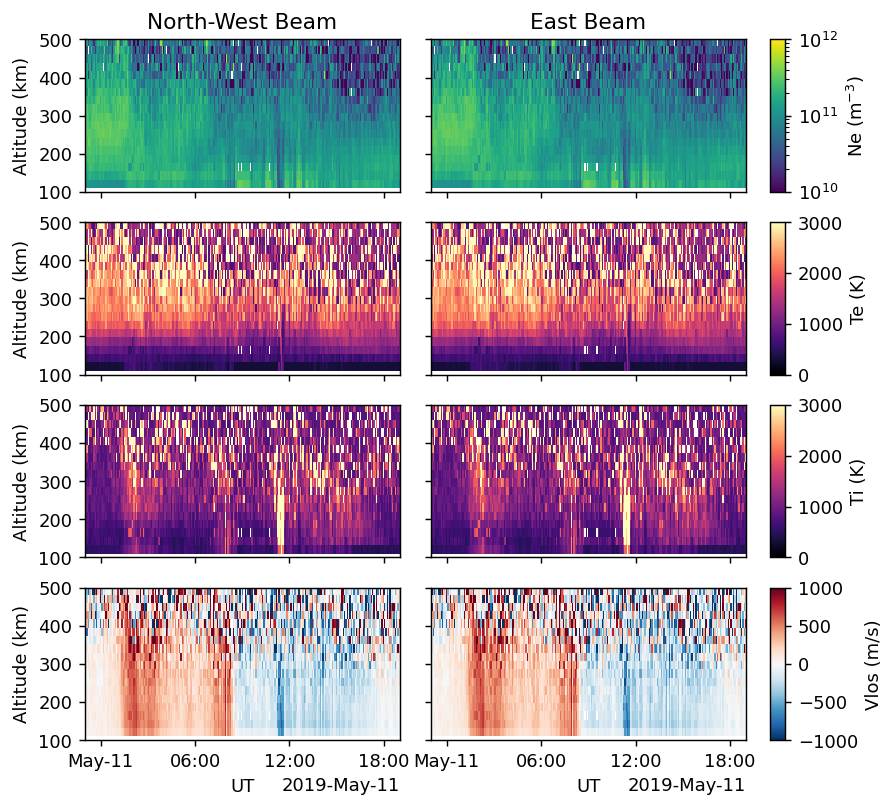

In [15]:
rows = 4
cols = 2
fig,axarr=plt.subplots(rows,cols,dpi=130,figsize=(8,7),sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.2))

for row,(datatype,beamrmodes,cbtxt,norm,ylims,cmap) in enumerate(zip(
                 ['ne','te','ti','vo'],
                 [[wdat,edat],[wdat,edat],[wdat,edat],[wdat,edat]],
                 [r"Ne (m$^{-3}$)", "Te (K)",
                   r"Ti (K)", "Vlos (m/s)"],
                 [mpl.colors.LogNorm(1e10,1e12),mpl.colors.Normalize(0,3000),mpl.colors.Normalize(0,3000),mpl.colors.Normalize(-1000,1000)],
                 [[100,500],[100,500],[100,500],[100,500]],
                 ['viridis','magma','magma','RdBu_r'])):
    for col,beamrmode in enumerate(beamrmodes):
        ax = axarr[row][col]
        pcm = ax.pcolormesh(mdates.date2num(beamrmode['time']),beamrmode['altitude']/1e3,beamrmode[datatype],
                      norm=norm,cmap=cmap,shading='nearest')
        ax.set_ylim(ylims)
        if col==0:
            ax.set_ylabel('Altitude (km)')
            vcb=fig.colorbar(pcm,ax=list(axarr[row][:].ravel()), pad=0.03, aspect=10)
            vcb.set_label(cbtxt)
        if row == rows-1:
            ax.set_xlabel('UT')

axarr[0,0].set_title('North-West Beam')
axarr[0,1].set_title('East Beam')

locator = mdates.AutoDateLocator(minticks=4, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
axarr[-1,-1].xaxis.set_major_locator(locator)
axarr[-1,-1].xaxis.set_major_formatter(formatter)
axarr[-1,-1].set_xlim([mdates.date2num(datetime.datetime(2019,5,10,23,0,0)),
                       mdates.date2num(datetime.datetime(2019,5,11,19,0,0))]);

# Questions

1. How are the line-of-sight velocities and ion temperatures related? What physical process causes that relationship?